# Шавель 853501 Лабораторная работа № 3

Вариант 25. Имеется одноканальная СМО с очередью, ограниченной числом мест R = 2. На вход СМО поступает простейший по ток заявок с интенсивностью X. Время обслуживания распределено по обобщенному закону Эрланга с параметрами k, X2. Найти вероятности состояний СМО и характеристики эффективности СМО.

По сути, единственным отличием в реализации относительно прошлой лабораторной работы является замена закона распределения для времени обслуживания на закон Эрланга:

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import heapq
import math
from collections import deque
from IPython.display import display, HTML

def sample(intensity):
    return np.random.exponential(1 / intensity)


def sample_erlang(shape, intensity):
    return np.random.gamma(shape, 1 / intensity)


class Action(Enum):
    REQUEST = 1
    SERVICE = 2
    LEAVE = 3
    

class Simulator:
    
    
    def __init__(self, channels_cnt, queue_size, rq_intensity, service_shape, service_intensity, leave_intensity):
        self.channels_cnt = channels_cnt
        self.queue_size = queue_size
        self.rq_intensity = rq_intensity
        self.service_shape = service_shape
        self.service_intensity = service_intensity
        self.leave_intensity = leave_intensity
    
    
    def get_product(self, limit):
        prod = 1
        beta = self.leave_intensity / self.service_intensity
        for l in range(1, limit + 1):
            prod *= self.channels_cnt + l * beta
        return prod
    
    
    def request(self, rq_id):
        if self.used_channels_cnt < self.channels_cnt:
            self.used_channels_cnt += 1
            heapq.heappush(self.events,
                           (self.current_time + 
                            sample_erlang(self.service_shape, self.service_intensity),
                           Action.SERVICE, 
                           rq_id))
        elif len(self.current_queue) < self.queue_size:
            self.current_queue.append(rq_id)
        else:
            pass
        
        rq_time = self.current_time + sample(self.rq_intensity)
        heapq.heappush(self.events, (rq_time, 
                                     Action.REQUEST, 
                                     self.current_rq_id))
        heapq.heappush(self.events, (rq_time + sample(self.leave_intensity), 
                                     Action.LEAVE, 
                                     self.current_rq_id))
        self.current_rq_id += 1
        
        
    def service(self, rq_id):
        if len(self.current_queue) == 0:
            self.used_channels_cnt -= 1
        else:
            heapq.heappush(self.events, (self.current_time + 
                                         sample_erlang(self.service_shape, self.service_intensity),
                                         Action.SERVICE,
                                         self.current_queue.popleft()))
            
    
    def leave(self, rq_id):
        if self.current_queue.count(rq_id):
            self.current_queue.remove(rq_id)
        
        
    def apply(self, action, rq_id):
        if action == Action.REQUEST:
            self.request(rq_id)
        elif action == Action.SERVICE:
            self.service(rq_id)
        elif action == Action.LEAVE:
            self.leave(rq_id)
            
            
    def run(self, total_time):
        self.used_channels_cnt = 0
        self.current_queue = deque()
        self.events = []
        self.current_time = 0
        self.total_time = total_time
        self.current_rq_id = 0
        state_probs = np.zeros(self.channels_cnt + self.queue_size + 1)
        rq_time = self.current_time + sample(self.rq_intensity)
        heapq.heappush(self.events, (rq_time, Action.REQUEST, 0))
        heapq.heappush(self.events, (rq_time + sample(self.leave_intensity), Action.LEAVE, 0))
        self.current_rq_id += 1
        while (self.events):
            item = heapq.heappop(self.events)
            passed_time = item[0] - self.current_time
            state = self.used_channels_cnt + len(self.current_queue)
            state_probs[state] += passed_time / self.total_time;
            self.current_time = item[0]
            if (self.current_time > self.total_time):
                break
            self.apply(item[1], item[2])
            
        passed_time = total_time - self.current_time
        state = self.used_channels_cnt + len(self.current_queue)
        state_probs[state] += passed_time / self.total_time;
        return state_probs
    
    
    def get_features(self, state_probs):
        ro = self.rq_intensity / self.service_intensity
        features = dict()
        p_reject = state_probs[self.channels_cnt] * (ro ** self.queue_size) / self.get_product(self.queue_size)
        Q = 1 - p_reject
        A = self.rq_intensity * Q
        avg_rq_smo = 0
        for i in range(self.channels_cnt + self.queue_size + 1):
            avg_rq_smo += state_probs[i] * i
        avg_rq_queue = 0
        for i in range(self.channels_cnt + 1, self.channels_cnt + self.queue_size + 1):
            avg_rq_queue += state_probs[i] * (i - self.channels_cnt)
        avg_channels_used = 0
        for i in range(self.channels_cnt + self.queue_size + 1):
            avg_channels_used += state_probs[i] * min(self.channels_cnt, i)
        avg_t_queue = avg_rq_queue / self.rq_intensity
        avg_t_smo = avg_t_queue + Q / self.service_intensity
        return [A, p_reject, avg_rq_smo, avg_rq_queue, avg_t_smo, avg_t_queue, avg_channels_used]

    
    def full_stat(self):
        emp_state_prob = self.run(30000)
        data = {'Эмпир. вероятности состояний': emp_state_prob.tolist()}
        df = pd.DataFrame(data)
        display(df)
        df.plot(kind='bar')
        plt.show()
        emp_features = self.get_features(emp_state_prob)
        indices = ['Абсолютная пропускная способность',
                  'Вероятность отказа',
                  'Среднее количество заявок в СМО',
                  'Среднее количество заявок в очереди',
                  'Среднее время нахождения заявки в СМО',
                  'Среднее время нахождения заявки в очереди',
                  'Среднее количество используемых каналов']
        df_features = pd.DataFrame({'Эмп. показатели':emp_features}, 
                                   index=indices)
        display(df_features)
        

,Эмпир. вероятности состояний
0,0.132410
1,0.232652
2,0.300685
3,0.334252


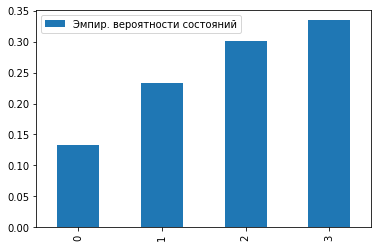

,Эмп. показатели
Абсолютная пропускная способность,0.218444
Вероятность отказа,0.344669
Среднее количество заявок в СМО,1.836779
Среднее количество заявок в очереди,0.969190
Среднее время нахождения заявки в СМО,6.184222
Среднее время нахождения заявки в очереди,2.907570
Среднее количество используемых каналов,0.867590


In [38]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/3,
              service_shape=1,
              service_intensity=1/5,
              leave_intensity=1/20)
sim.full_stat()

Далее иследуем СМО при различных значениях тех параметров, которые не зафиксированы условием задачи:

Попробуем изменить параметр распределния Эрланга (service_shape). По логике, при его увеличении должно увеличиться среднее время на обслуживание, т.к. распределение Эрланга с параметром k, характеризует время ожидания до того, как в Пуассоновском потоке событие произойдет k раз. Протестируем симуляцией:

,Эмпир. вероятности состояний
0,0.031864
1,0.137134
2,0.330104
3,0.500899


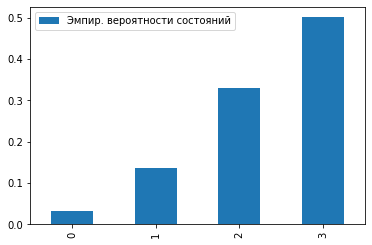

,Эмп. показатели
Абсолютная пропускная способность,0.265613
Вероятность отказа,0.203161
Среднее количество заявок в СМО,2.300037
Среднее количество заявок в очереди,1.331901
Среднее время нахождения заявки в СМО,7.979898
Среднее время нахождения заявки в очереди,3.995704
Среднее количество используемых каналов,0.968136


In [39]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/3,
              service_shape=2,
              service_intensity=1/5,
              leave_intensity=1/20)
sim.full_stat()

,Эмпир. вероятности состояний
0,0.004664
1,0.074255
2,0.293770
3,0.627311


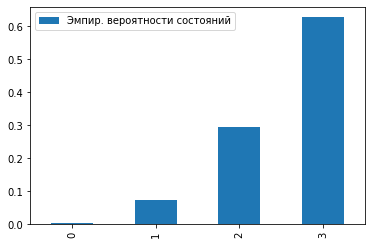

,Эмп. показатели
Абсолютная пропускная способность,0.296664
Вероятность отказа,0.110008
Среднее количество заявок в СМО,2.543728
Среднее количество заявок в очереди,1.548392
Среднее время нахождения заявки в СМО,9.095134
Среднее время нахождения заявки в очереди,4.645175
Среднее количество используемых каналов,0.995336


In [40]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/3,
              service_shape=4,
              service_intensity=1/5,
              leave_intensity=1/20)
sim.full_stat()

Как можно заметить, вероятности сдвигаются больше в правую сторону, т.е. очередь плотнее заполняется, что и потверждает нашу гипотезу. Далее попробуем увеличить второй параметр закона Эрланга, по сути интенсивность:

,Эмпир. вероятности состояний
0,0.270188
1,0.284236
2,0.255848
3,0.189729


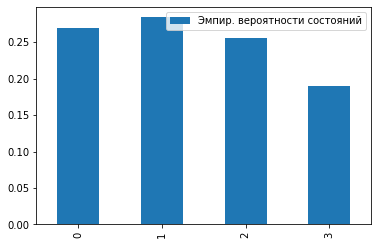

,Эмп. показатели
Абсолютная пропускная способность,0.269959
Вероятность отказа,0.190124
Среднее количество заявок в СМО,1.365118
Среднее количество заявок в очереди,0.635306
Среднее время нахождения заявки в СМО,4.335544
Среднее время нахождения заявки в очереди,1.905917
Среднее количество используемых каналов,0.729812


In [41]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/3,
              service_shape=1,
              service_intensity=1/3,
              leave_intensity=1/20)
sim.full_stat()

,Эмпир. вероятности состояний
0,0.438050
1,0.293818
2,0.172862
3,0.095270


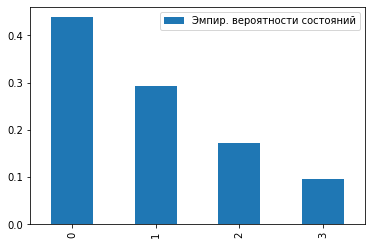

,Эмп. показатели
Абсолютная пропускная способность,0.300357
Вероятность отказа,0.098929
Среднее количество заявок в СМО,0.925352
Среднее количество заявок в очереди,0.363402
Среднее время нахождения заявки в СМО,2.892349
Среднее время нахождения заявки в очереди,1.090206
Среднее количество используемых каналов,0.561950


In [42]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/3,
              service_shape=1,
              service_intensity=1/2,
              leave_intensity=1/20)
sim.full_stat()

В данном случае, очередь становится более свободной, что логично, так как мы увеличивали интенсивность обслуживания. Далее попробуем увеличить оба параметра одновременно:

,Эмпир. вероятности состояний
0,0.079997
1,0.199912
2,0.341501
3,0.378590


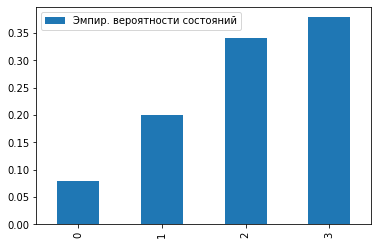

,Эмп. показатели
Абсолютная пропускная способность,0.288760
Вероятность отказа,0.133720
Среднее количество заявок в СМО,2.018684
Среднее количество заявок в очереди,1.098681
Среднее время нахождения заявки в СМО,5.894880
Среднее время нахождения заявки в очереди,3.296042
Среднее количество используемых каналов,0.920003


In [43]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/3,
              service_shape=2,
              service_intensity=1/3,
              leave_intensity=1/20)
sim.full_stat()

,Эмпир. вероятности состояний
0,0.034387
1,0.154976
2,0.355068
3,0.455569


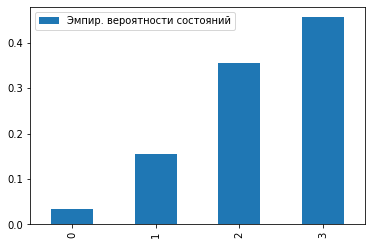

,Эмп. показатели
Абсолютная пропускная способность,0.315940
Вероятность отказа,0.052181
Среднее количество заявок в СМО,2.231820
Среднее количество заявок в очереди,1.266207
Среднее время нахождения заявки в СМО,5.694259
Среднее время нахождения заявки в очереди,3.798620
Среднее количество используемых каналов,0.965613


In [44]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/3,
              service_shape=4,
              service_intensity=1/2,
              leave_intensity=1/20)
sim.full_stat()

В целом, можно наблюдать, что параметры компенсируют друг друга в каком-то смысле, однако первый все-таки имеет больший эффект, так как вероятности немного сдвигаются вправо. Далее попробуем уменшить интенсивность потока заявок:

,Эмпир. вероятности состояний
0,0.131881
1,0.279810
2,0.342125
3,0.246184


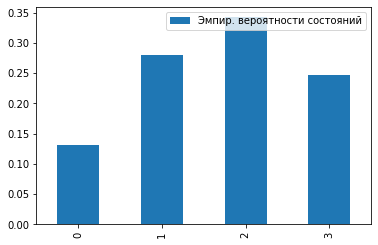

,Эмп. показатели
Абсолютная пропускная способность,0.193217
Вероятность отказа,0.033916
Среднее количество заявок в СМО,1.702612
Среднее количество заявок в очереди,0.834493
Среднее время нахождения заявки в СМО,6.104633
Среднее время нахождения заявки в очереди,4.172466
Среднее количество используемых каналов,0.868119


In [45]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/5,
              service_shape=4,
              service_intensity=1/2,
              leave_intensity=1/20)
sim.full_stat()

Вполне логично, система лучше справляется с обработкой. И в конце, попробуем уменьшить предельное время ожидания заявок в очереди:

,Эмпир. вероятности состояний
0,0.206428
1,0.396031
2,0.278746
3,0.118794


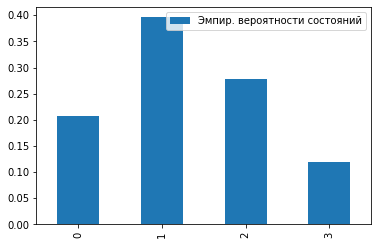

,Эмп. показатели
Абсолютная пропускная способность,0.193728
Вероятность отказа,0.031362
Среднее количество заявок в СМО,1.309906
Среднее количество заявок в очереди,0.516335
Среднее время нахождения заявки в СМО,4.518949
Среднее время нахождения заявки в очереди,2.581674
Среднее количество используемых каналов,0.793572


In [46]:
sim = Simulator(channels_cnt=1, 
              queue_size=2, 
              rq_intensity=1/5,
              service_shape=4,
              service_intensity=1/2,
              leave_intensity=1/7)
sim.full_stat()

Как и можно было ожидать, очередь стала более свободной, среднее кол-во заявок в ней уменьшилось